#-----------------------------------------------------------------------------

#1er Code de réseaux de neurones

---



In [46]:
import tensorflow as tf                #importer la bibiotheque tensorflow pour réaliser les architectures de reseaux de neurones
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt   #importer pyplot pour les visualisations

In [48]:
#je vais utiliser cette fonction pour charger toutes mes images dans mon directory

df = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/PlantVillage",
    shuffle = True, #pour randomiser les calculs dans le
    image_size = (256,256), #la taille de l'image
    batch_size = 32  #combien de trainig on le fait pour une iteration par defaut 32 mais peut monter 64,128,256 etc
)


Found 2152 files belonging to 3 classes.


In [49]:
import numpy as np     #importer les bibliotèques panda et numpy pour traiter les données sous faormat tableau
import pandas as pd
df


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [55]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):    #Nous divisons les données en données d'entrainement, de test et de validation
  df_size = len(ds)

  if shuffle:           #on utlise shuffle pour bien randomiser les données
    ds = df.shuffle(shuffle_size, seed=12)
  train_size = int(train_split * df_size)
  val_size = int(val_split * df_size)

  train_df = df.take(train_size)

  validation = df.skip(train_size).take(val_size)
  test_ds = df.skip(train_size).skip(val_size)

  return train_df, validation, test_ds

In [56]:
train_df, validation, test_ds = get_dataset_partitions_tf(df)

In [57]:
len(train_df)  #conaitre la taille du jeu d'entrainement

54

In [58]:
len(validation) #conaitre la taille du jeu de validation

6

In [59]:
len(test_ds) #conaitre la taille du jeu de test

8

In [60]:
train_dr = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)       #optimisation, randomisation des jeux de données pour etre préparer à ce que le mmodèle tourne
validation_ds = validation.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [61]:
from tensorflow.keras import layers  #normalisation des images pour limiter l'empreinte des valeurs extremes
from tensorflow import keras

ress_resc = keras.Sequential([
    layers.Rescaling(1.0/255, input_shape=(256, 256, 3))
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [62]:
 from tensorflow.keras import layers   #application d'une amélioration des image en augmentant la diversification de la partie d'entrainement (souvent appliquée pour mieux généraliser les données d'entrainement)
from tensorflow import keras

data_augmentation = keras.Sequential([
   layers.RandomFlip("horizontal_and_vertical"),
   layers.RandomRotation(0.2),
])


On va à présent construire le modèle

In [63]:
model = models.Sequential([             #defintion de l'architecture du model sequentiel avec 1 couche convolutive, une couche pooling pour applatir les données et deux fonctions d'activation relu et softmax avec en derner 3 pour nous donner l'affectation au niveau des 3 classes
    ress_resc,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])
model.build(input_shape=(None, 256, 256, 3))

In [ ]:
model.summary()     #nous donne un resumé des caractéristiques de chaque couche et les output

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 516128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      33,032,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,033,347 (126.01 MB)

 Trainable params: 33,033,347 (126.01 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)    #Nous compilons en choisissant l'optimiser adam le plus utilisé généralement ave comme métrique la précision qui est l'accuracy

In [65]:
mod1 = model.fit(
    train_df,
    batch_size=32,
    validation_data=validation,
    verbose=1,
    epochs=10
)  # Nous faisons tourner notre modèle avec 10 epochs (iterations), pour voir s'il converge vite

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


54/54 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.4174 - loss: 11.0882 - val_accuracy: 0.5469 - val_loss: 0.6762
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.6090 - loss: 0.6621 - val_accuracy: 0.8542 - val_loss: 0.4093
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.8504 - loss: 0.4292 - val_accuracy: 0.8281 - val_loss: 0.3892
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - accuracy: 0.8786 - loss: 0.3302 - val_accuracy: 0.8177 - val_loss: 0.4334
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.8840 - loss: 0.2875 - val_accuracy: 0.9219 - val_loss: 0.2299
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - accuracy: 0.8796 - loss: 0.2783 - val_accuracy: 0.8594 - val_loss: 0.3313
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.8961 - loss: 0.2536 - val_accuracy: 0.7969 - val_loss: 0.4352
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.8890 - loss: 0.2625 - val_accuracy: 0.8906 - val_loss: 0

In [67]:
scores = model.evaluate(test_ds)   #le modèel a convergé rapidement et l'accuracy est élevée

8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9540 - loss: 0.1332


Text(0.5, 1.0, 'Training and Validation Loss')

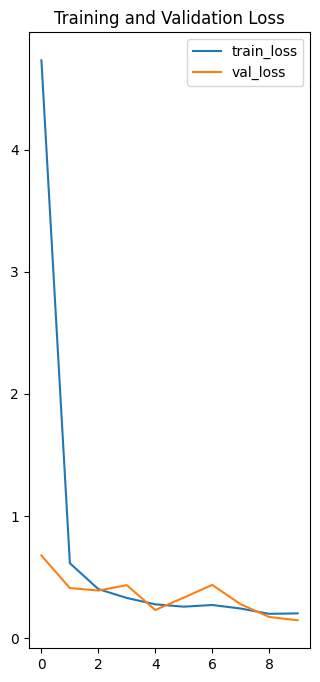

In [71]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(mod1.history['loss'], label='train_loss')
plt.plot(mod1.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Training and Validation Accuracy')

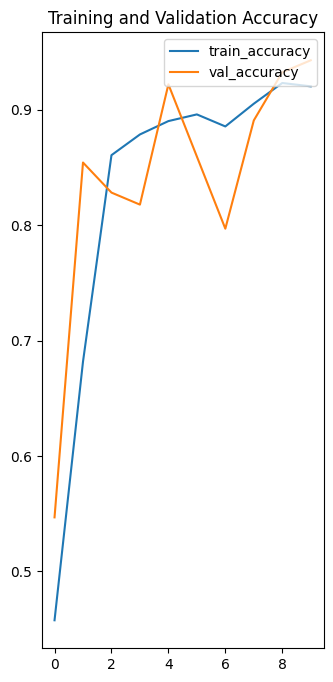

In [72]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(mod1.history['accuracy'], label='train_accuracy')
plt.plot(mod1.history['val_accuracy'], label='val_accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')


In [73]:
for images, labels in test_ds.take(1):
  prediction = model.predict(images)
  print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
[[4.8305714e-04 5.5166942e-01 4.4784757e-01]
 [2.1611471e-03 5.2991807e-01 4.6792072e-01]
 [9.9950975e-01 4.9016770e-04 6.6191647e-14]
 [6.1238278e-04 2.3925051e-01 7.6013714e-01]
 [9.9995047e-01 4.9522194e-05 1.1094784e-14]
 [1.0752680e-01 8.9168912e-01 7.8407407e-04]
 [6.3887965e-03 9.4489294e-01 4.8718188e-02]
 [3.1877207e-03 8.2216281e-01 1.7464936e-01]]


In [74]:
class_names = df.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
predicted label: Potato___Early_blight


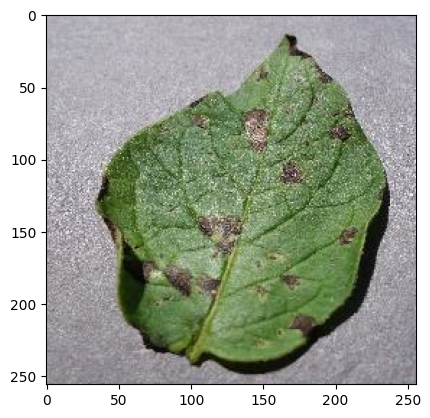

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
[9.0153170e-01 9.8468356e-02 4.6776034e-08]


In [75]:
for images, labels in test_ds.take(1):   #pour afficher la classe observée et la classe estimée
  first_image = images[0].numpy().astype('uint8')
  first_label = labels[0].numpy()
  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:", class_names[first_label])
  batch_prediction = model.predict(images)
  print("predicted label:", class_names[np.argmax(batch_prediction[0])])
  plt.show()

print(class_names)
prediction = model.predict(images)   #pour afficher les probabilités d'appartenance à chaque classe
print(prediction[0])

# Les classes sont déséquilibrées il ya donc par conséquent une trse bonne precision equilibrons les classes et appliquons le modèle

# -----------------------------------

APPLICATION DE SMOTE

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [23]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/PlantVillage",
    shuffle = True, #pour randomiser les calculs dans le modele
    image_size = (150,150), #ici je reduis la taille de l'image pour minimiser le nombre de paramètres
    batch_size = 32  #combien de trainig on le fait pour une iteration par defaut 32 mais peut monter 64,128,256 etc
)


Found 2152 files belonging to 3 classes.


In [24]:
from sklearn.model_selection import train_test_split

image_list = []                  #nous chargeons les images et les etiquetes du jeu de données
label_list = []

for images, labels in df:
    image_list.append(images)
    label_list.append(labels)

X = tf.concat(image_list, axis=0).numpy()   #pour appliquer le modèle il faut retranscrire les images en tensor
y = tf.concat(label_list, axis=0).numpy()

# Split du dataset en 80% entraînement et 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)   #nous divisions notre jeu de données


In [25]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Nous aplatissons les images en vue d'appliquer SMOTE


In [26]:
sm = SMOTE(sampling_strategy='minority', random_state=42)   #nous appliquons smote tout en randomisant et reequilibrant par rapport à la classe minoritaire
X_smote, y_smote = sm.fit_resample(X_train_reshaped, y_train)


In [27]:
X_smote = X_smote.reshape(-1, 150, 150, 3)  # Nous remettons en forme les images pour pouvoir construire et etablir le modèle


In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),  # Modifié à 150x150
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),  # Aplatissement de l'entrée pour la couche Dense
    tf.keras.layers.Dense(64, activation='relu'),  # nous appliquons une couche dense après Flatten
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes de sortie
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.summary()  #nous voyons que les output de chaque couche

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       5,308,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,328,067 (20.32 MB)

 Trainable params: 5,328,067 (20.32 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])   #Nous compilons notre modèle

In [35]:
history = model.fit(X_smote, y_smote, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.5217 - loss: 285.7159 - val_accuracy: 0.6891 - val_loss: 0.6971
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.8653 - loss: 0.4150 - val_accuracy: 0.7077 - val_loss: 0.7567
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9403 - loss: 0.1922 - val_accuracy: 0.8167 - val_loss: 0.9887
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9899 - loss: 0.0440 - val_accuracy: 0.8121 - val_loss: 1.2283
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.9899 - loss: 0.0400 - val_accuracy: 0.7912 - val_loss: 1.0947
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9985 - loss: 0.0146 - val_accuracy: 0.7773 - val_loss: 1.1636
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.9878 - loss: 0.0538 - val_accuracy: 0.8144 - val_loss: 1.6709
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9934 - loss: 0.0231 - val_accuracy: 0.8028 -

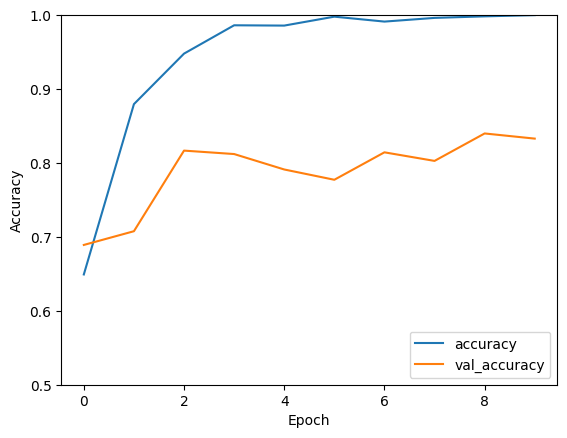

In [36]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

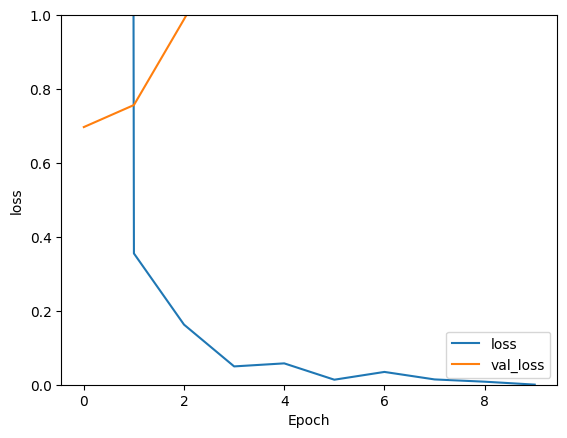

In [37]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [39]:
predictions = model.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 895ms/step


In [40]:
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)  # les classes predites (etiquettes prédites)

class_labels = list(train_generator.class_indices.keys()) #recuperation des  classes


y_pred_labels = [class_labels[i] for i in y_pred_classes] #pour maper les indices avec leur classes

# Afficher les prédictions sous forme de noms de classe
print("Classes prédites : ", y_pred_labels)  #pour afficher les classes predites de tout le jeu de données
confusion_matrix = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_classes)
print(confusion_matrix) #Nous affichons la matrice de confusion

14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 546ms/step
Classes prédites :  ['Potato___Late_blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___healthy', 'Potato___healthy', 'Potato___Late_blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___Late_blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___Early_blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___Late_

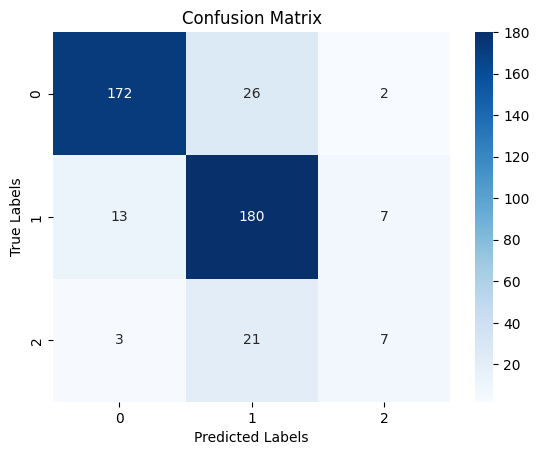

In [43]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
scores = model.evaluate(y_test)    #Nous affichons la matrice de confusion à l'aide de la bibliothèque seaborn